# The All-Knowing Cube of Probability

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Suppose you run $n$ trials where the probability of success is $p$.
To compute the probability of $k$ successes, we can use the binomial distribution.

For example, here's a range of value for $k$ and $n$, and a discrete grid of values for $p$.

In [4]:
ks = np.arange(101)
ns = np.arange(101)
ps = np.linspace(0, 1, 101)

We can use `meshgrid` to make a 3-D grid of $k$, $n$, and $p$, and `binom` to evaluate the binomial PMF at each point.

In [5]:

from scipy.stats import binom

K, N, P = np.meshgrid(ks, ns, ps, indexing='ij')
cube = binom.pmf(K, N, P)
cube.shape

(101, 101, 101)

The result is the all-knowing cube of probability, so-called because it can answer all of our questions about Bernoulli trials.
Allow me to demonstrate.

## The binomial distribution

Suppose we are given $n$ and $p$, and we would like to know the distribution of $k$.
We can answer that question by selecting a vector from the cube along the $k$ axis.

In [6]:
n = 50
p = 50
pmf_k = cube[:, n, p]

The result is a normalized PMF.

In [7]:
pmf_k.sum()

0.9999999999999996

Here's what it looks like.

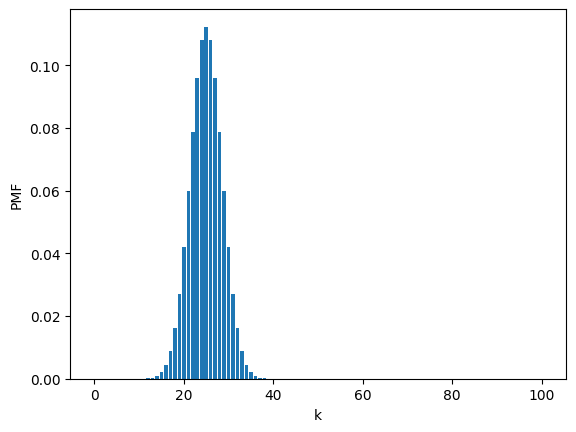

In [8]:
plt.bar(ks, pmf_k)
plt.xlabel('k')
plt.ylabel('PMF');

Because we used `binom` to compute the cube, we should not be surprised to find that this slice from the cube is a binomial PMF.
But just to make sure, we can use `binom` again to confirm it.

In [9]:
pmf_binom = binom.pmf(ks, n, p/100)

In [10]:
np.allclose(pmf_k, pmf_binom)

True

So we can think of the cube as a collection of binomial PMFs.
But we can also think of it as a joint distribution of $k$, $n$, and $p$, which raises the question: what do we get if we select a vector along the $n$ and $p$ axes?

## The negative binomial distribution

Suppose we plan to run Bernoulli trials with probability $p$ until we see $k$ successes.
How many trials will it take?

We can answer this question by selecting a vector from the cube along the $n$ axis.

In [11]:
k = 25
p = 50
pmf_n = cube[k, :, p].copy()

The result is close to the answer we want, but there's something we have to fix.
Remember that the values in the cube come from the binomial PMF, which looks like this.

$$Pr(k; n, p) = \binom{n}{k} p^{k} (1-p)^{n-k}$$

The first term is the binomial coefficient, which indicates that there are $n$ places we could find $k$ successes.
But if we keep running trials until we see $k$ successes, we know the last trial will be a success, which means there are only $n-1$ places we could find the other $k-1$ successes.

So we have to adjust the values from the cube by dividing the elements by $n/k$.

In [12]:
pmf_n /= (ns / k)
pmf_n[0] = 0

/tmp/ipykernel_125703/780240301.py:1: RuntimeWarning: invalid value encountered in divide
  pmf_n /= (ns / k)


Now we have to normalize the results to get a proper PMF.

In [13]:
pmf_n /= pmf_n.sum()

Here's what it looks like.

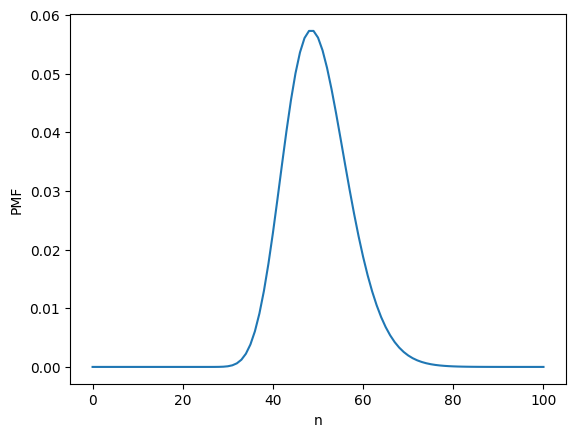

In [14]:
plt.plot(ks, pmf_n)
plt.xlabel('n')
plt.ylabel('PMF');

This is a negative binomial distribution, which we can confirm using `nbinom`.

In [15]:
from scipy.stats import nbinom

pmf_nbinom = nbinom.pmf(ns-k, k, p/100)
pmf_nbinom.sum()

0.9999999094998685

In [16]:
np.allclose(pmf_n, pmf_nbinom)

True

To see why this works we can compare the binomial PMF, which is a distribution over $k$ with $n$ and $p$ as parameters:

$$Pr(k; n, p) = \binom{n}{k} p^{k} (1-p)^{n-k}$$

And the negative binomial PMF, which I've written as a distribution over $n$ with $k$ and $p$ as parameters:

$$Pr(n; k, p) = \binom{n-1}{k-1} p^k (1-p)^{n-k}$$

This is not the most common way to parameterize the negative binomial distribution, but it shows that the only difference is in the binomial coefficient, because we know that the last trial is a success.

## The beta distribution

Suppose we have 101 devices that perform Bernoulli trials with different probabilities.
One device has $p=0$, one has $p=0.01$, one has $p=0.02$, and so on up to one device with $p=1$.

Now suppose we choose one of the devices so that all values of $p$ are equally likely.
If we run $n$ trials and see $k$ successes, what is the distribution of $p$?

We can answer this question by selecting a vector from the cube along the $p$ axis.

In [65]:
k = 25
n = 50
k = 6
n = 12
pdf_p = cube[k, n, :].copy()

The result is not normalized.

In [66]:
pdf_p.sum()

7.692307692307231

But we can normalize it like this.

In [67]:
pdf_p /= pdf_p.sum()

And here's what it looks like.

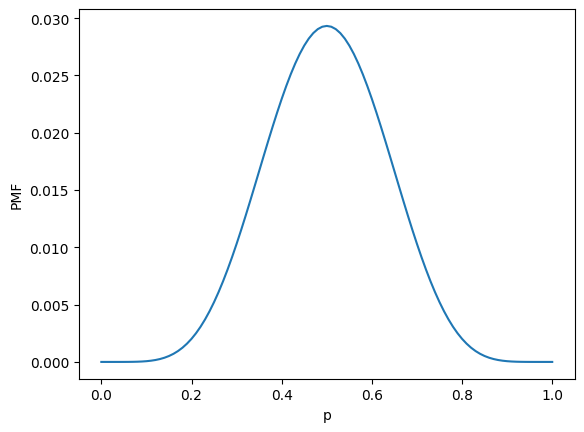

In [68]:
plt.plot(ps, pdf_p)
plt.xlabel('p')
plt.ylabel('PMF');

This is a beta distribution, which we can confirm by running `beta` with a change of variables, $a = k+1$ and $b = n-k+1$.

In [69]:
from scipy.stats import beta

a = k + 1
b = n - k + 1
a, b

(7, 7)

In [70]:
pdf_beta = beta.pdf(ps, a, b)
pdf_beta /= pdf_beta.sum()

In [71]:
np.allclose(pdf_p, pdf_beta)

True

In [72]:
a - 1, b + k - 1

(6, 12)

To see why this works, let's compare the PDF of the beta distribution

$$f(p, a, b) = \frac{1}{B(a, b)} p^{a-1} (1-p)^{b-1} $$

And the PMF of the binomial distribution.

$$Pr(k; n, p) = \binom{n}{k} p^{k} (1-p)^{n-k}$$

With the change of variables, they are identical except for the first term, which normalizes the distributions.

## Conjugate priors

This similarity is the reason the beta and binomial are conjugate distributions, which means they are joined together.
This relationship has a useful property for Bayesian statistics: if the prior distribution for $p$ is beta and the likelihood of the data is binomial, the posterior distribution is also beta.

To see how that works, suppose the prior distribution of $p$ is beta with parameters $a$ and $b$. Here is the PDF of that distribution:

$$p^{a-1} (1-p)^{b-1}$$

I have omitted the normalizing factor, which we don't need because we are going to normalize the distribution after the update.

Now suppose we see $k$ successes in $n$ trials.
The likelihood of this data is given by the binomial distribution, which has this PMF.

$$p^{k} (1-p)^{n-k}$$

Again, I have omitted the normalizing factor.
Now to get the unnormalized posterior, we multiply the beta prior and the binomial likelihood. The result is

$$p^{a-1+k} (1-p)^{b-1+n-k}$$

which we recognize as an unnormalized beta distribution with parameters $a+k$ and $b+n-k$.

So if we observe $k$ successes in $n$ trials, we can do the update by making a beta distribution with parameters $a+k$ and $b+n-k$.

As an example, let's start with a beta prior.

In [73]:
a = 2
b = 3

prior = beta.pdf(ps, a, b)

And suppose we see 5 successes in 10 attempts.

In [74]:
k = 5
n = 10

like = binom.pmf(k, n, ps)

We can compute the posterior by multiplying the prior and the likelihood, then normalizing the results.

In [75]:
posterior = prior * like
posterior /= posterior.sum()

Or we can compute a beta distribution with the updated parameters.

In [76]:
posterior_beta = beta.pdf(ps, a+k, b+n-k)
posterior_beta /= posterior_beta.sum()

The result is the same either way.

In [77]:
np.allclose(posterior, posterior_beta)

True

## The all-knowing cube knows all

In [89]:
def get_beta(a, b, cube):
    k = a - 1
    n = b + k - 1

    pdf= cube[k, n, :].copy()
    pdf /= pdf.sum()
    return pdf

In [90]:
a, b, k, n

(2, 3, 5, 10)

In [91]:
posterior_cube = get_beta(a + k, b + n - k, cube)

In [93]:
np.allclose(posterior_beta, posterior_cube)

True

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)